In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.trials_data import TrialsData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants,def_task
import os 

In [2]:
filepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/pfc/2022-11-30_10-42-03_Riesling_pfc_e1_r1.h5"
s_path = os.path.normpath(filepath).split(os.sep)
data = TrialsData.from_python_hdf5(filepath)

### Block 2

In [3]:
# Select trials and create task frame
block = 2
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == block))[0]
print("Number of clusters: %d" % len(data.clustersgroup))

Number of clusters: 56


In [4]:
# Define target codes 
target_codes= {
    # code: [ML axis], [plot axis]
    '127': [[10,0],[1,2]],
    '126': [[7,7],[0,2]],
    '125': [[0,10],[0,1]],
    '124': [[-7,7],[0,0]],
    '123': [[-10,0],[1,0]],
    '122': [[-7,-7],[2,0]],
    '121': [[0,-10],[2,1]],
    '120': [[7,-7],[2,2]],
}
# create dict with the trials that have each code
trials_idx = {}
for i_key,key in enumerate(target_codes.keys()):
    trials = []
    code_idx=[]
    for i_trial,code in zip(trial_idx, data.code_numbers[trial_idx]):
        idx=np.where(int(key) == code)[0]
        if len(idx)!=0:
            code_idx.append(idx[0])
            trials.append(i_trial)
    trials_idx[key]={'code_idx':code_idx,'trials_idx':trials}

#### t-test for each epoch 

In [5]:
# check whether the neuron is responding to the task comparing each epoch with fixation 
codes = ['124','120','125','121','126','122','127','123']
all_e_aling = ['target_on','target_off','fix_spot_off']
all_t_after = [100,800,200]
t_test:Dict[str,list] = defaultdict(list)
for i_neuron in range(len(data.clustersgroup)):
    for e_align, t_after in zip(all_e_aling,all_t_after):
        event_align = task_constants.EVENTS_B2[e_align]
        mean_sp=[]
        for code in codes:
            target_t_idx = trials_idx[code]["trials_idx"] # select trials with the same stimulus
            trials_ev = data.code_samples[
                target_t_idx,
                np.where(data.code_numbers[target_t_idx] == event_align)[1]]
            shift_sp = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_ev).astype(int), axis=1)[:, :t_after]
            mean_sp = shift_sp.mean(axis=0)

            trials_ev = data.code_samples[
                target_t_idx,
                np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2['target_on'])[1]]
            shift_sp = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_ev-200).astype(int), axis=1)[:, :200]
            mean_sp_fix = shift_sp.mean(axis=0)
            p=stats.ttest_ind(mean_sp, mean_sp_fix)[1]
            t_test['code']+=[code]
            t_test['cluster']+=[i_neuron]
            t_test['group']+=[data.clustersgroup[i_neuron]]
            t_test['event']+=[e_align]
            t_test['p']+=[p]
t_test_sacc = pd.DataFrame(t_test)


/tmp/ipykernel_52552/790264225.py:16: RuntimeWarning: Mean of empty slice.
  mean_sp = shift_sp.mean(axis=0)
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_52552/790264225.py:22: RuntimeWarning: Mean of empty slice.
  mean_sp_fix = shift_sp.mean(axis=0)


#### sacaddic index

In [6]:
# search the location where there is the higher activity
def compute_sacc_idx(data,e_align,e_after):
    left = np.array(['125','124','123','122'])
    right = np.array(['121','120','127','126'])
    sacc_index = []
    event_align = task_constants.EVENTS_B2[e_align]
    for i_neuron in range(len(data.clustersgroup)):#[np.where(data.clustersgroup=='good')[0][5]]:#
        #all_mean_sp=[]
        max_activity = 0
        code_sp = {}
        if i_neuron == 23:
            i = 1
        for r_side, l_side in zip(right,left):
            for code in [r_side, l_side]:
                target_t_idx = trials_idx[code]["trials_idx"] # select trials with the same stimulus
                if len(target_t_idx) != 0:
                    trials_ev = data.code_samples[
                        target_t_idx,
                        np.where(data.code_numbers[target_t_idx] == event_align)[1]]
                    if e_after != 'eye_in_target':
                        trials_e_after = data.code_samples[
                            target_t_idx,
                            np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2[e_after])[1]]-trials_ev        
                    else:
                        trials_e_after = data.code_samples[
                            target_t_idx,
                            np.where(data.code_numbers[target_t_idx] == task_constants.EVENTS_B2[e_after])[1][0]]-trials_ev     
                    shift_sp = TrialsData.indep_roll(data.sp_samples[target_t_idx,i_neuron], -(trials_ev ).astype(int), axis=1)#[:, :t_after]
                    all_sp=[]
                    for i,t_after in enumerate(trials_e_after):
                        all_sp.append(shift_sp[i,:int(t_after)])
                    if len(all_sp) == 0:
                        mean_sp=0
                    else:
                        mean_sp = np.concatenate(all_sp).mean() 
                else:
                    mean_sp=0
                #mean_sp = shift_sp.mean()
                code_sp[code]=mean_sp
                if mean_sp > max_activity:
                    max_activity = mean_sp 
                    p_value = t_test_sacc[(t_test_sacc['code']==code) & (t_test_sacc['cluster']==i_neuron) & (t_test_sacc['event']==e_align)]['p'].values[0]<0.05
                    pair = [r_side, l_side]
                #all_mean_sp.append(np.array(mean_sp)) 
        mean_r = code_sp[pair[0]]
        mean_l = code_sp[pair[1]]  
        if (mean_r==0 and mean_l==0) or p_value == False:
            sacc_index.append(np.nan)
        else:
            sacc_index.append((mean_r-mean_l)/(mean_r+mean_l))
    return sacc_index

In [7]:
sacc_index_target = compute_sacc_idx(data,e_align='target_on',e_after='target_off')
sacc_index_delay = compute_sacc_idx(data,e_align='target_off',e_after='fix_spot_off')
sacc_index_sacc = compute_sacc_idx(data,e_align='fix_spot_off',e_after='eye_in_target')

### Block 1

In [8]:
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
task = def_task.create_task_frame(
    condition=data.condition[trial_idx],
    test_stimuli=data.test_stimuli[trial_idx],
    samples_cond=task_constants.SAMPLES_COND,
)
trials_sp = data.sp_samples[trial_idx]

### t-test 

In [9]:
# check whether the neuron is responding to the task comparing each epoch with fixation 

all_e_aling = ['sample_on','sample_off','test_on_1']
all_t_after = [450,450,450]
t_test:Dict[str,list] = defaultdict(list)
for i_neuron in range(len(data.clustersgroup)):
    for e_align, t_after in zip(all_e_aling,all_t_after):
        event_align = task_constants.EVENTS_B1[e_align]
        trials_s_on = data.code_samples[
            trial_idx,
            np.where(data.code_numbers[trial_idx] == event_align)[1],
        ]
        neuron_sp = trials_sp[:, i_neuron, :]
        shift_sp = TrialsData.indep_roll(neuron_sp, -(trials_s_on).astype(int), axis=1)[:, :t_after]             
        # fix
        trials_s_on = data.code_samples[
            trial_idx,
            np.where(data.code_numbers[trial_idx] == task_constants.EVENTS_B1['sample_on'])[
                1
            ],
        ]
        neuron_sp = trials_sp[:, i_neuron, :]
        shift_sp_fix = TrialsData.indep_roll(neuron_sp, -(trials_s_on-200).astype(int), axis=1)[:, :200]       
        for i_cond, cond in enumerate(["in", "out"]):
            sample_idx = task[task["in_out"] == cond]["trial_idx"].values
            mean_sp = shift_sp[sample_idx].mean(axis=0)
            mean_sp_fix = shift_sp_fix[sample_idx].mean(axis=0)
            p=stats.ttest_ind(mean_sp, mean_sp_fix)[1]
            t_test['cond']+=[cond]
            t_test['cluster']+=[i_neuron]
            t_test['group']+=[data.clustersgroup[i_neuron]]
            t_test['event']+=[e_align]
            t_test['p']+=[p]
t_test_dmts = pd.DataFrame(t_test)

In [10]:
# search the location where there is the higher activity
def compute_dmts_idx(data,e_align,e_after):
    dmts_index = []
    trials_s_on = data.code_samples[
        trial_idx,
        np.where(data.code_numbers[trial_idx] == task_constants.EVENTS_B1[e_align])[
            1
        ],
    ]

    trials_e_after = data.code_samples[
        trial_idx,
        np.where(data.code_numbers[trial_idx] == task_constants.EVENTS_B1[e_after])[
            1
        ],
    ]-trials_s_on
    for i_neuron in range(len(data.clustersgroup)):
        neuron_sp = trials_sp[:, i_neuron, :]
        shift_sp = TrialsData.indep_roll(neuron_sp, -(trials_s_on).astype(int), axis=1)#[:, :t_after]
        code_sp = {}
        for i_cond, cond in enumerate(["in", "out"]):
            sample_idx = task[task["in_out"] == cond]["trial_idx"].values
            all_sp=[]
            for i,t_after in enumerate(trials_e_after[sample_idx]):
                all_sp.append(shift_sp[sample_idx][i,:int(t_after)])
            mean_sp = np.concatenate(all_sp).mean() 
            #mean_sp = shift_sp[sample_idx].mean()
            code_sp[cond] = mean_sp         
        mean_r = code_sp['in']
        mean_l = code_sp['out']  
        if mean_r> mean_l:
            p_value = t_test_dmts[(t_test_dmts['cond']=='in') & (t_test_dmts['cluster']==i_neuron) & (t_test_dmts['event']==e_align)]['p'].values[0]<0.5
        else:
            p_value = t_test_dmts[(t_test_dmts['cond']=='out') & (t_test_dmts['cluster']==i_neuron) & (t_test_dmts['event']==e_align)]['p'].values[0]<0.5
        if (mean_r==0 and mean_l==0) or (p_value == False):
            dmts_index.append(np.nan)
        else:
            dmts_index.append((mean_r-mean_l)/(mean_r+mean_l))
    return dmts_index

In [11]:
dmts_index_sample = compute_dmts_idx(data,e_align='sample_on',e_after='sample_off')
dmts_index_delay = compute_dmts_idx(data,e_align='sample_off',e_after='test_on_1')
dmts_index_test1 = compute_dmts_idx(data,e_align='test_on_1',e_after='test_off_1')

In [12]:
def plot_idxs(idx1,idx2,name1,name2):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.scatter(idx1,idx2,s=6)
    ax.vlines(0,np.nanmin(idx2),np.nanmax(idx2),'k')
    ax.hlines(0,np.nanmin(idx1),np.nanmax(idx1),'k')
    ax.set(xlabel=name1, ylabel=name2)
    good,mua=1,1
    
    for i, txt in enumerate(data.clustersgroup):
        if txt =='good':
            good+=1
            i_cluster = good
        else:
            mua+=1
            i_cluster = mua
            if i_cluster == 19:
                print(i)
        ax.annotate(str(i_cluster)+txt, (idx1[i], idx2[i]),size=6)

35
35
35


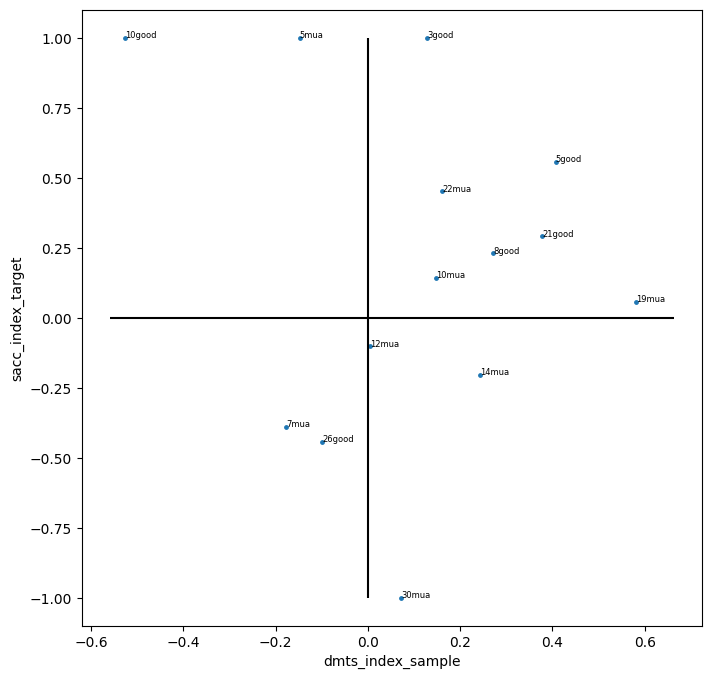

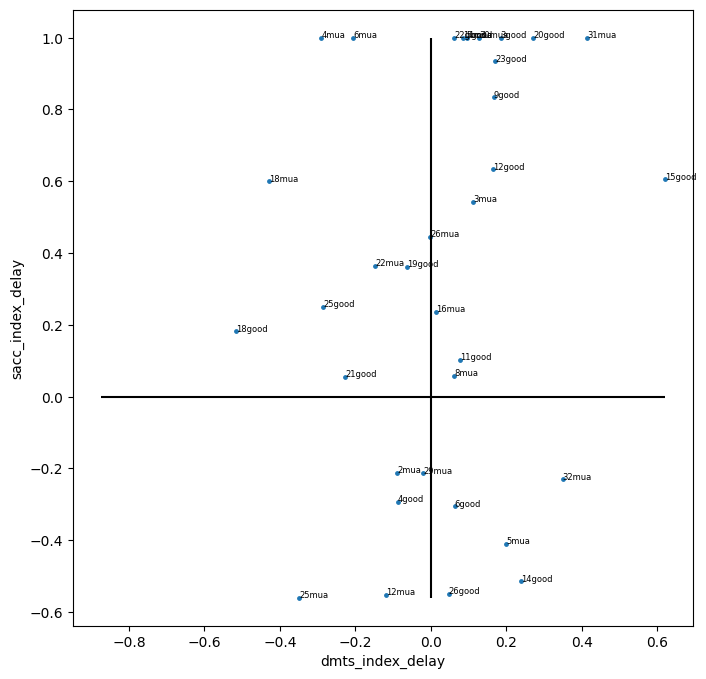

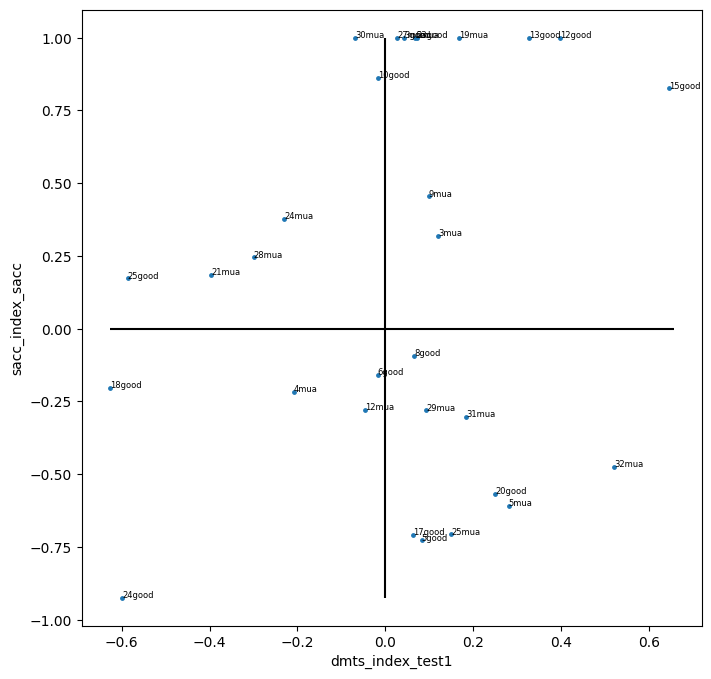

: 

In [13]:
plot_idxs(dmts_index_sample,sacc_index_target,"dmts_index_sample","sacc_index_target")
plot_idxs(dmts_index_delay,sacc_index_delay,"dmts_index_delay","sacc_index_delay")
plot_idxs(dmts_index_test1,sacc_index_sacc,"dmts_index_test1","sacc_index_sacc")